# data1030 project
## EDA

In [2]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.11.4"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.11"):
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.24.4", 'matplotlib': "3.7.2",'sklearn': "1.3.0", 
                'pandas': "2.0.3",'xgboost': "1.7.6", 'shap': "0.42.1", 'seaborn': "0.12.2"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.11.4

[ OK ] numpy version 1.24.4 is installed.
[ OK ] matplotlib version 3.7.2 is installed.
[ OK ] sklearn version 1.3.0 is installed.
[ OK ] pandas version 2.0.3 is installed.
[ OK ] xgboost version 1.7.6 is installed.


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


[ OK ] shap version 0.42.1 is installed.
[ OK ] seaborn version 0.12.2 is installed.


In [3]:
# load everything in
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv("data/Building_Permits.csv")
np.random.seed(0)

Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.


Index(['Permit Number', 'Permit Type', 'Permit Type Definition',
       'Permit Creation Date', 'Block', 'Lot', 'Street Number',
       'Street Number Suffix', 'Street Name', 'Street Suffix', 'Unit',
       'Unit Suffix', 'Description', 'Current Status', 'Current Status Date',
       'Filed Date', 'Issued Date', 'Completed Date',
       'First Construction Document Date', 'Structural Notification',
       'Number of Existing Stories', 'Number of Proposed Stories',
       'Voluntary Soft-Story Retrofit', 'Fire Only Permit',
       'Permit Expiration Date', 'Estimated Cost', 'Revised Cost',
       'Existing Use', 'Existing Units', 'Proposed Use', 'Proposed Units',
       'Plansets', 'TIDF Compliance', 'Existing Construction Type',
       'Existing Construction Type Description', 'Proposed Construction Type',
       'Proposed Construction Type Description', 'Site Permit',
       'Supervisor District', 'Neighborhoods - Analysis Boundaries', 'Zipcode',
       'Location', 'Record ID'],
     


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


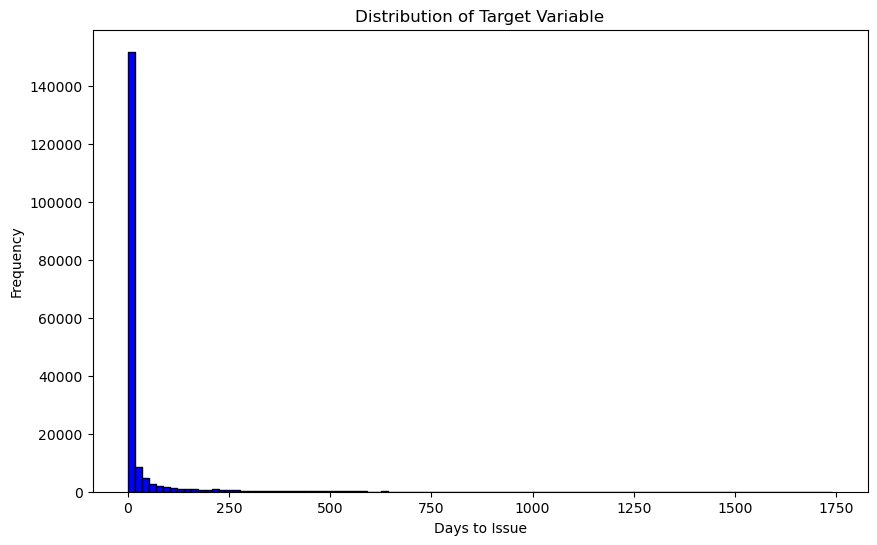

1740
26.054696673189824
0.0


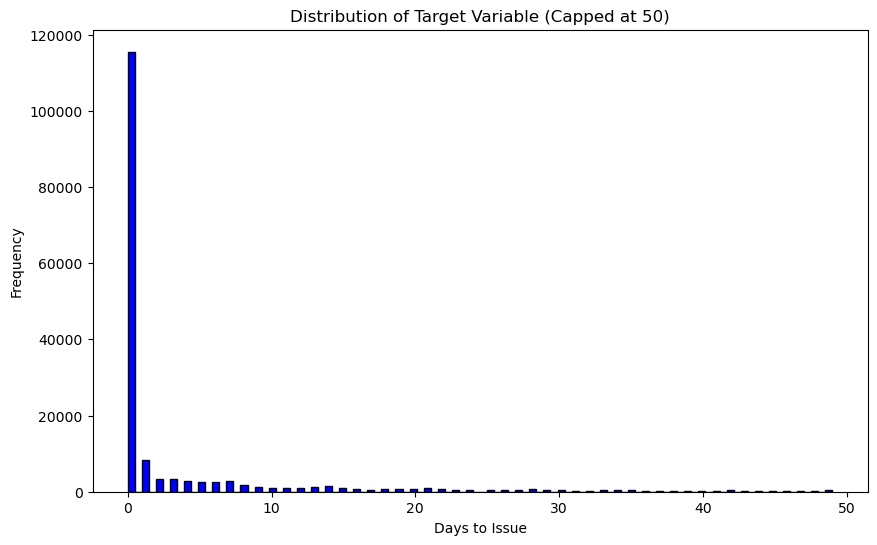

In [4]:
# get a glimpse of data
pd.set_option('display.max_columns', None)
df.sample(5)

# understand the shape of the data and the labels of the columns
print(df.columns)
print(len(df.index))
print(len(df.columns))
# calculating target variable column (number of days between filing a permit and being issued one)
df['days_to_issue'] = pd.to_datetime(df['Issued Date']) - pd.to_datetime(df['Filed Date'])
# setting that column as the "target variable"
target_var = df['days_to_issue']
for i in range(len(target_var)):
    target_var[i] = target_var[i].days
# converting dates to integer of days since 1/1/2013
for column in df.columns:
    if column.endswith('Date'):
        df[column] = df[column].apply(lambda x: (pd.to_datetime(x) - pd.to_datetime('2013-01-01')).days if x is not None else x)
# creating a histogram of the target variable
hist = target_var.plot(kind='hist', figsize=(10, 6), bins=100, color='blue', edgecolor='black')
plt.title('Distribution of Target Variable')
plt.xlabel('Days to Issue')
plt.ylabel('Frequency')
plt.show()

# target_var description
print(target_var.max())
print(target_var.mean())
print(target_var.median())
# target variable ranges from 0 days to 997 days
# regression problem - predicting the number of days between filing a permit and being issued one

# capping target_var at 50 for viz purposes
target_var_50 = target_var.copy()
target_var_50 = target_var_50[target_var_50 < 50]
hist2 = target_var_50.plot(kind='hist', figsize=(10, 6), bins=100, color='blue', edgecolor='black')
plt.title('Distribution of Target Variable (Capped at 50)')
plt.xlabel('Days to Issue')
plt.ylabel('Frequency')
plt.show()



In [5]:
target_var.value_counts()
#what percent of the target variable is 0?
percent_zero = target_var.value_counts()[0]/len(target_var)
# how many 0s are there in the target variable?
print(target_var.value_counts()[0])
print(percent_zero)

115488
0.580633484162896


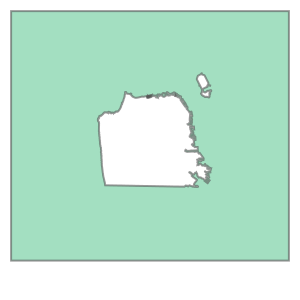

In [6]:
# geographic breakdown of the data
# using geopandas library to plot the data on a map of San Francisco
# https://towardsdatascience.com/making-heat-maps-with-literal-maps-how-to-use-python-to-construct-a-chloropleth-6b65e4e33905
sf_map = gpd.read_file("data/sfoutline.shp")
sf_map['geometry'][0]
# goal for the future...




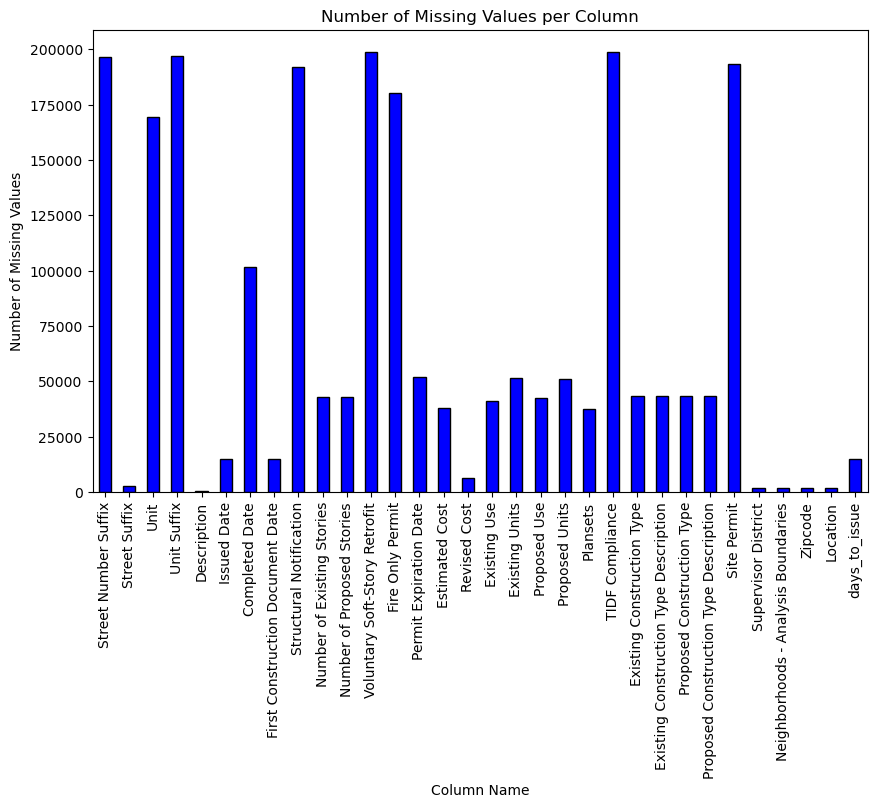

TIDF Compliance                  198898
Voluntary Soft-Story Retrofit    198865
Unit Suffix                      196939
Street Number Suffix             196684
Site Permit                      193541
Structural Notification          191978
Fire Only Permit                 180073
Unit                             169421
Completed Date                   101709
Permit Expiration Date            51880
dtype: int64
Proposed Units                    50911
Existing Units                    51538
Permit Expiration Date            51880
Completed Date                   101709
Unit                             169421
Fire Only Permit                 180073
Structural Notification          191978
Site Permit                      193541
Street Number Suffix             196684
Unit Suffix                      196939
Voluntary Soft-Story Retrofit    198865
TIDF Compliance                  198898
dtype: int64
0.25833916083916086
2260881
8751600


In [7]:
missing_value_count = df.isnull().sum()
# plotting missing values by column
missing_value_count[missing_value_count > 0].plot(kind='bar', figsize=(10, 6), color='blue', edgecolor='black')
plt.title('Number of Missing Values per Column')
plt.xlabel('Column Name')
plt.ylabel('Number of Missing Values')
plt.show()

# printing 10 columns with most missing values
print(missing_value_count.sort_values(ascending=False).head(10))
# only 12 columns without missing values
print(missing_value_count.sort_values(ascending=True).tail(12))
# total percentage of empty cells
print(missing_value_count.sum()/(len(df.index)*len(df.columns)))
print(missing_value_count.sum())
print(len(df.index)*len(df.columns))
# 26% of cells are empty

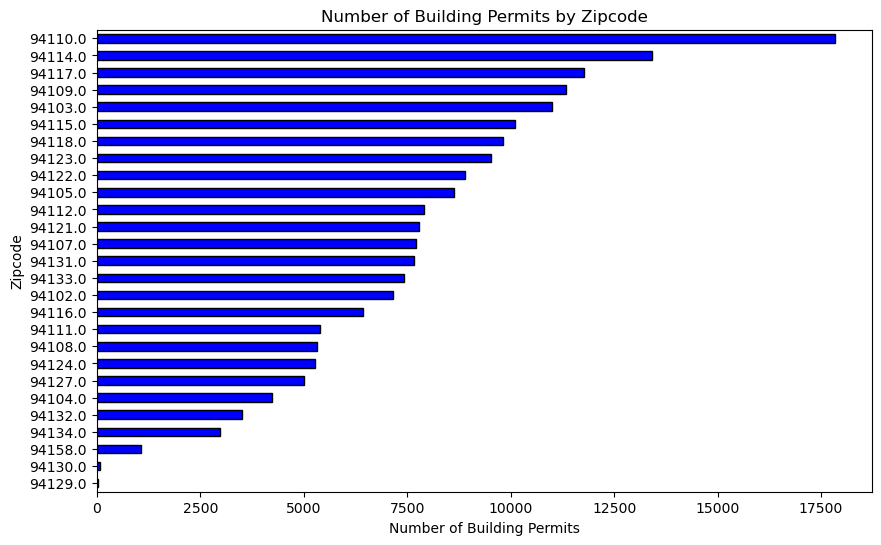

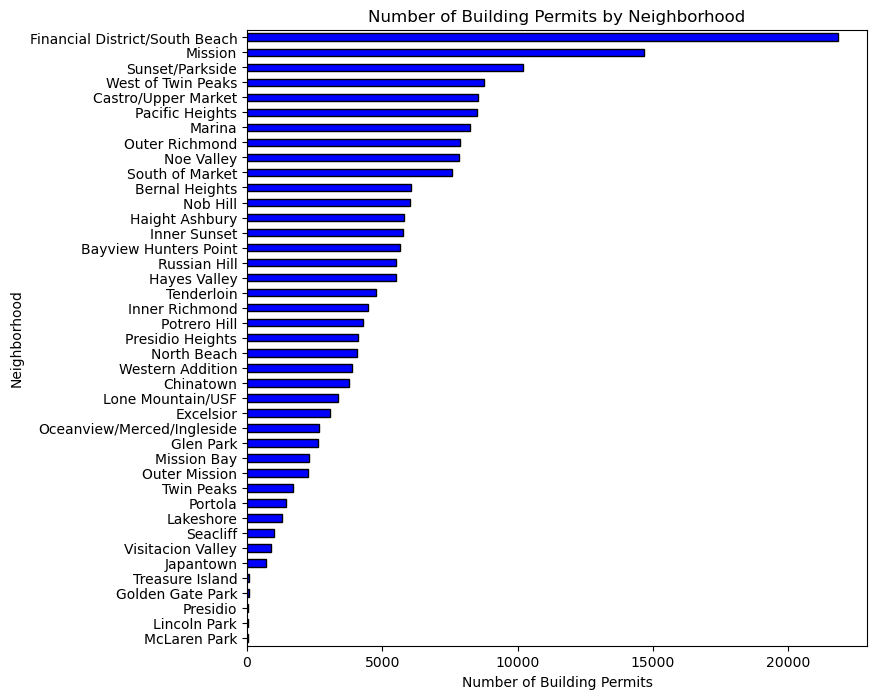

In [8]:
# bar plot of # of building permits by zipcode
df['Zipcode'].value_counts().sort_values(ascending=True).plot(kind='barh', figsize=(10, 6), color='blue', edgecolor='black')
plt.title('Number of Building Permits by Zipcode')
plt.xlabel('Number of Building Permits')
plt.ylabel('Zipcode')
plt.show()

# bar plot of # of building permits by neighborhood
df['Neighborhoods - Analysis Boundaries'].value_counts().sort_values(ascending=True).plot(kind='barh', figsize=(8, 8), color='blue', edgecolor='black')
plt.title('Number of Building Permits by Neighborhood')
plt.xlabel('Number of Building Permits')
plt.ylabel('Neighborhood')
plt.show()

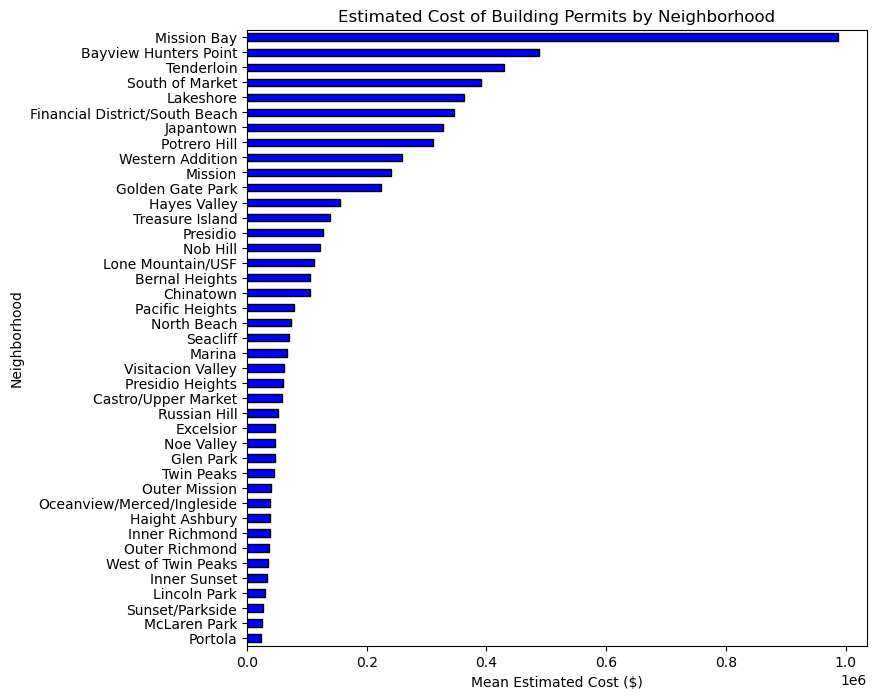

Neighborhoods - Analysis Boundaries
Mission Bay                       986416.468203
Bayview Hunters Point             487010.991886
Tenderloin                        429540.259706
South of Market                   391403.944213
Lakeshore                         362270.375591
Financial District/South Beach    345188.666637
Japantown                         328012.295082
Potrero Hill                      310990.056164
Western Addition                  259131.716567
Mission                           241151.031765
Golden Gate Park                  224320.189655
Hayes Valley                      155384.108458
Treasure Island                   138222.728148
Presidio                          126518.250000
Nob Hill                          121293.007845
Lone Mountain/USF                 111467.638040
Bernal Heights                    105492.505652
Chinatown                         104996.394490
Pacific Heights                    78648.127577
North Beach                        74224.623492
Seac

In [9]:
# bar plot of estimated cost by neighborhood
df.groupby('Neighborhoods - Analysis Boundaries')['Estimated Cost'].mean().sort_values(ascending=True).plot(kind='barh', figsize=(8, 8), color='blue', edgecolor='black')
plt.title('Estimated Cost of Building Permits by Neighborhood')
plt.xlabel('Mean Estimated Cost ($)')
plt.ylabel('Neighborhood')
plt.show()
print(df.groupby('Neighborhoods - Analysis Boundaries')['Estimated Cost'].mean().sort_values(ascending=False))


# -----------------------------------------------------
## SPLITTING + PREPROCESSING
# -----------------------------------------------------

In [10]:
# split function
def basic_split(X, y, train_size, val_size, test_size, random_state):
    if (train_size+val_size+test_size) != 1:
        raise ValueError("train_size, val_size, and test_size must sum to 1")
    if not isinstance(random_state, int):
        raise ValueError("random_state must be an integer")
    if not isinstance(X, pd.DataFrame):
        raise ValueError("X must be a DataFrame")
    if not isinstance(y, pd.Series):
        raise ValueError("y must be a Series")
    if len(X) != len(y):
        raise ValueError("X and y must have the same length")
    X_train, X_temp, y_train, y_temp =\
        train_test_split(X, y, train_size=train_size, random_state=random_state)
    X_val, X_test, y_val, y_test =\
        train_test_split(X_temp, y_temp, test_size=\
            test_size/(1-train_size), random_state=random_state)
    if len(X_train) != int(train_size*len(X)) and len(X_train) !=\
          int(train_size*len(X))+1 and len(X_train) !=\
              int(train_size*len(X))-1:
        raise ValueError("train_size is incorrect in the outputs")
    if len(X_val) != int(val_size*len(X)) and len(X_val) !=\
          int(val_size*len(X))+1 and len(X_val) !=\
              int(val_size*len(X))-1:
        raise ValueError("val_size is incorrect in the outputs")
    if len(X_test) != int(test_size*len(X)) and len(X_test) !=\
          int(test_size*len(X))+1 and len(X_test) !=\
              int(test_size*len(X))-1:
        raise ValueError("test_size is incorrect in the outputs")
    return X_train, X_val, X_test, y_train, y_val, y_test

#setting feature matrix + target variable
X = df.drop('days_to_issue', axis=1)
y = df['days_to_issue']

#establishing random state
random_state = 42

#splitting data into train, val, and test sets
split_data = train_test_split(X, y, random_state)
X_train, X_val, X_test, y_train, y_val, y_test = split_data

# checking that the split is correct
print(len(X_train))
print(len(X_val))
print(len(X_test))
print(len(X_train)/len(X) == 0.6)
print(len(X_val)/len(X) == 0.2)
print(len(X_test)/len(X) == 0.2)

119340
39780
39780
True
True
True


In [11]:
X_train.head(5)
# df['Existing Use'].value_counts()
# df block histogram to distribute


,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,Unit,Unit Suffix,Description,Current Status,Current Status Date,Filed Date,Issued Date,Completed Date,First Construction Document Date,Structural Notification,Number of Existing Stories,Number of Proposed Stories,Voluntary Soft-Story Retrofit,Fire Only Permit,Permit Expiration Date,Estimated Cost,Revised Cost,Existing Use,Existing Units,Proposed Use,Proposed Units,Plansets,TIDF Compliance,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
18783,201307172011,8,otc alterations permit,197,5642,041,41,NaN,Godeus,St,NaN,NaN,re-roofing,complete,205,197,197.0,205.0,197.0,NaN,3.0,3.0,NaN,NaN,557.0,9000.0,9000.0,2 family dwelling,2.0,2 family dwelling,2.0,0.0,NaN,5.0,wood frame (5),5.0,wood frame (5),NaN,9.0,Bernal Heights,94110.0,"(37.742687976312496, -122.42101127662643)",1311268453161
114912,201602189892,3,additions alterations or repairs,1143,5843,007,526,NaN,Alemany,Bl,NaN,NaN,"rad. bldg 17, replace exterior & interior door...",issued,1302,1143,1302.0,NaN,1400.0,NaN,2.0,2.0,NaN,NaN,2382.0,1982000.0,1982000.0,apartments,6.0,apartments,6.0,2.0,NaN,5.0,wood frame (5),5.0,wood frame (5),Y,9.0,Bernal Heights,94110.0,"(37.73302575101365, -122.41667663903435)",1413056264319
66976,201411071026,8,otc alterations permit,675,2395,020,2926,NaN,Ulloa,St,NaN,NaN,reroofing,complete,687,675,675.0,687.0,675.0,NaN,2.0,2.0,NaN,NaN,1035.0,13000.0,13000.0,1 family dwelling,1.0,1 family dwelling,1.0,0.0,NaN,5.0,wood frame (5),5.0,wood frame (5),NaN,4.0,Sunset/Parkside,94116.0,"(37.74088687574616, -122.48789839140807)",1361744134212
57373,201408083393,8,otc alterations permit,584,6592,023,336,NaN,Duncan,St,NaN,NaN,"replace damage broken siding, replace damage/b...",complete,602,584,584.0,602.0,584.0,NaN,2.0,2.0,NaN,NaN,944.0,3800.0,4000.0,apartments,3.0,apartments,3.0,0.0,NaN,5.0,wood frame (5),5.0,wood frame (5),NaN,8.0,Noe Valley,94131.0,"(37.746231746880696, -122.4285179313817)",1351686252222
31656,M445647,8,otc alterations permit,323,1233,007,129,NaN,Central,Av,NaN,NaN,street space,issued,323,323,323.0,NaN,323.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,Haight Ashbury,94117.0,"(37.770784022673524, -122.44404823388055)",1324770277723


In [12]:
mvc = X_train.isnull().sum() / len(X_train)
print(X_train.shape)
# identify columns with greater than 50% missing values
mvc[mvc > 0.5]
columns_to_remove = mvc[mvc > 0.5].index
print(columns_to_remove)
for column in columns_to_remove:
    X_train.drop(column, axis=1, inplace=True)
    X_val.drop(column, axis=1, inplace=True)
    X_test.drop(column, axis=1, inplace=True)

# remove rows that do not have an issued date and as such don't have a target variable
X_train = X_train[X_train['Issued Date'].notnull()]
X_val = X_val[X_val['Issued Date'].notnull()]
X_test = X_test[X_test['Issued Date'].notnull()]

(119340, 43)
Index(['Street Number Suffix', 'Unit', 'Unit Suffix', 'Completed Date',
       'Structural Notification', 'Voluntary Soft-Story Retrofit',
       'Fire Only Permit', 'TIDF Compliance', 'Site Permit'],
      dtype='object')


In [13]:
# preprocessing

# for column in X_train.columns:
#     if column.endswith('Date'):
#         X_train[column] = X_train[column].apply(lambda x: (pd.to_datetime(x)-pd.to_datetime("01/01/2013")).days if pd.notnull(x) else x)
# for column in X_val.columns:
#     if column.endswith('Date'):
#         X_val[column] = X_val[column].apply(lambda x: (pd.to_datetime(x)-pd.to_datetime("01/01/2013")).days if pd.notnull(x) else x)
# for column in X_test.columns:
#     if column.endswith('Date'):
#         X_test[column] = X_test[column].apply(lambda x: (pd.to_datetime(x)-pd.to_datetime("01/01/2013")).days if pd.notnull(x) else x)
# print(X_train.dtypes)
onehot_ftrs = ['Permit Type', 'Permit Type Definition', 'Current Status', 'Existing Use', 'Proposed Use', 'Supervisor District', 'Neighborhoods - Analysis Boundaries', 'Zipcode']
minmax_ftrs = ['Permit Creation Date', 'Current Status Date', 'First Construction Document Date', 'Permit Expiration Date']
std_ftrs = ['Number of Existing Stories', 'Number of Proposed Stories', 'Estimated Cost', 'Revised Cost', 'Existing Units', 'Proposed Units', 'Plansets']

preprocessor = ColumnTransformer(
    transformers=[
        # ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)

print(X_train.shape)
print(X_train_prep.shape)
print(X_train_prep)

print(X_train.isnull().sum())


# X_train_prep.head()


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


(110403, 34)
(110403, 302)
[[ 0.          0.          0.         ... -0.18155944 -0.18976713
  -1.15886378]
 [ 0.          0.          1.         ... -0.12794275 -0.13669034
   0.85821775]
 [ 0.          0.          0.         ... -0.19496361 -0.20303633
  -1.15886378]
 ...
 [ 0.          0.          0.         ... -0.19496361 -0.20303633
  -1.15886378]
 [ 0.          0.          0.         ... -0.08773023 -0.09688275
   0.85821775]
 [ 0.          0.          0.         ... -0.20836779 -0.21630552
   0.85821775]]
Permit Number                                 0
Permit Type                                   0
Permit Type Definition                        0
Permit Creation Date                          0
Block                                         0
Lot                                           0
Street Number                                 0
Street Name                                   0
Street Suffix                              1485
Description                                  50
C

In [23]:
new_df = pd.read_csv("data/Building_Permits.csv")
new_df['days_to_issue'] = pd.to_datetime(new_df['Issued Date']) - pd.to_datetime(new_df['Filed Date'])
# setting that column as the "target variable"
target_var = new_df['days_to_issue']
for i in range(len(target_var)):
    target_var[i] = target_var[i].days
# converting dates to integer of days since 1/1/2013
for column in new_df.columns:
    if column.endswith('Date'):
        new_df[column] = new_df[column].apply(lambda x: (pd.to_datetime(x) - pd.to_datetime('2013-01-01')).days if x is not None else x)

new_df = new_df[new_df['Issued Date'].notnull()]
mvc = X.isnull().sum() / len(X_train)
columns_to_remove = mvc[mvc > 0.5].index
for column in columns_to_remove:
    X.drop(column, axis=1, inplace=True)
random_state = 42

X = new_df.drop('days_to_issue', axis=1)
y = new_df['days_to_issue']



onehot_ftrs = ['Permit Type', 'Permit Type Definition', 'Current Status', 'Existing Use', 'Proposed Use', 'Supervisor District', 'Neighborhoods - Analysis Boundaries', 'Zipcode']
minmax_ftrs = ['Permit Creation Date', 'Current Status Date', 'First Construction Document Date', 'Permit Expiration Date']
std_ftrs = ['Number of Existing Stories', 'Number of Proposed Stories', 'Estimated Cost', 'Revised Cost', 'Existing Units', 'Proposed Units', 'Plansets']

preprocessor = ColumnTransformer(
    transformers=[
        # ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)])

prep = Pipeline(steps=[('preprocessor', preprocessor)])

# X_train_prep = clf.fit_transform(X_train)
# X_val_prep = clf.transform(X_val)
# X_test_prep = clf.transform(X_test)

# print(X_train.shape)
# print(X_train_prep.shape)
# print(X_train_prep)

# print(X_train.isnull().sum())


Columns (22,32) have mixed types. Specify dtype option on import or set low_memory=False.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

def MLpipe_KFold_RMSE(X, y, preprocessor, ML_algo, param_grid):
    '''
    This function splits the data to other/test (80/20) and then applies KFold with 4 folds to other.
    The RMSE is minimized in cross-validation.

    You should:

    1. Loop through 10 different random states
    2. Split your data 
    3. Fit a model using GridSearchCV with KFold and the predefined Preprocessor 
    4. Calculate the model's error on the test set 
    5. Return a list of 10 test scores and 10 best models 
    '''
    
    # lists to be returned 
    test_scores = []
    best_models = []


    rmse = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

    # your code here...
    # 1. loop through 10 different random states
    for random_state in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
        # 2. split the data
        X_other, X_test, y_other, y_test = train_test_split(X, y,\
                                        test_size=0.2, random_state = random_state)
        kf = KFold(n_splits=4, shuffle=True, random_state=random_state)
        pipe = make_pipeline(preprocessor, ML_algo)
        # 3. fit a model using GridSearchCV with KFold and the predefined Preprocessor
        model = GridSearchCV(pipe, param_grid, scoring=rmse, cv=kf)
        model.fit(X_other, y_other)
        best_models.append(model)
        # 4. calculate the model's error on the test set
        test_score = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
        test_scores.append(test_score)

    return test_scores, best_models

param_grids = {
    'Lasso': {'lasso__alpha': np.logspace(-3, 3, 7)},
    'Ridge': {'ridge__alpha': np.logspace(-3, 3, 7)},
    'ElasticNet': {'elasticnet__alpha': np.logspace(-3, 3, 7),
                   'elasticnet__l1_ratio': [0.2, 0.5, 0.8]},
    'RandomForest': {'randomforestregressor__n_estimators': [10, 50, 100],
                     'randomforestregressor__max_depth': [10, 20]},
    'SVR': {'svr__C': np.logspace(-3, 3, 7),
            'svr__gamma': ['scale', 'auto']},
    'KNN': {'kneighborsregressor__n_neighbors': [1, 3, 5, 10]}
}

lasso_model = Lasso(random_state=42)
ridge_model = Ridge(random_state=42, max_iter=10000)
elasticnet_model = ElasticNet(random_state=42, max_iter=10000)
randomforest_model = RandomForestRegressor(random_state=42)
svr_model = SVR()
knn_model = KNeighborsRegressor()

l1_test_scores, l1_best_models = MLpipe_KFold_RMSE(X, y, preprocessor,\
                                            lasso_model, param_grids['Lasso'])
l2_test_scores, l2_best_models = MLpipe_KFold_RMSE(X, y, preprocessor,\
                                            ridge_model, param_grids['Ridge'])
en_test_scores, en_best_models = MLpipe_KFold_RMSE(X, y, preprocessor,\
                                            elasticnet_model, param_grids['ElasticNet'])
rf_test_scores, rf_best_models = MLpipe_KFold_RMSE(X, y, preprocessor,\
                                            randomforest_model, param_grids['RandomForest'])
svr_test_scores, svr_best_models = MLpipe_KFold_RMSE(X, y, preprocessor,\
                                            svr_model, param_grids['SVR'])
knn_test_scores, knn_best_models = MLpipe_KFold_RMSE(X, y, preprocessor,\
                                            knn_model, param_grids['KNN'])
print(f"Mean L1 Test RMSE: {np.mean(l1_test_scores)}")
print(f"Standard Deviation of L1 Test RMSE: {np.std(l1_test_scores)}")
print('\n')
print(f"Mean L2 Test RMSE: {np.mean(l2_test_scores)}")
print(f"Standard Deviation of L2 Test RMSE: {np.std(l2_test_scores)}")
print('\n')
print(f"Mean Elastic Net Test RMSE: {np.mean(en_test_scores)}")
print(f"Standard Deviation of Elastic Net Test RMSE: {np.std(en_test_scores)}")
print('\n')
print(f"Mean Random Forest Test RMSE: {np.mean(rf_test_scores)}")
print(f"Standard Deviation of Random Forest Test RMSE: {np.std(rf_test_scores)}")
print('\n')
print(f"Mean SVR Test RMSE: {np.mean(svr_test_scores)}")
print(f"Standard Deviation of SVR Test RMSE: {np.std(svr_test_scores)}")
print('\n')
print(f"Mean KNN Test RMSE: {np.mean(knn_test_scores)}")
print(f"Standard Deviation of KNN Test RMSE: {np.std(knn_test_scores)}")

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
`sparse` was renamed to `sparse_output` in version 1

ValueError: 
All the 28 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
28 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/data1030/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/envs/data1030/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/data1030/lib/python3.11/site-packages/sklearn/pipeline.py", line 420, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/miniconda3/envs/data1030/lib/python3.11/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/data1030/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py", line 905, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/data1030/lib/python3.11/site-packages/sklearn/base.py", line 621, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/data1030/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1147, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/opt/miniconda3/envs/data1030/lib/python3.11/site-packages/sklearn/utils/validation.py", line 959, in check_array
    _assert_all_finite(
  File "/opt/miniconda3/envs/data1030/lib/python3.11/site-packages/sklearn/utils/validation.py", line 124, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/opt/miniconda3/envs/data1030/lib/python3.11/site-packages/sklearn/utils/validation.py", line 173, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
Lasso does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
